In [2]:
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
from torch import nn
import torch
import os 
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import argparse
import numpy as np
import random
import copy
import cv2
import urllib.request

/home/d_mamul/miniconda3/envs/course_work/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# import opendatasets as od
# od.download('https://www.kaggle.com/datasets/yudhaislamisulistya/plants-type-datasets')

In [4]:
# img = ImageFolder("tinyimagenettorch/tiny-imagenet-200/train")
img = ImageFolder('plants-type-datasets')
dataset = {
    0: [],
    1: []
}
dataset[1] = [i[0] for i in img.imgs]
# for i in range(200):
#     temp = (i+1)*500
#     dataset[1] += [i[0] for i in img.imgs[temp-200:temp]]
img = ImageFolder("mushrooms").imgs#  + ImageFolder("govno kakoeto").imgs + ImageFolder("Mushroom").imgs  
dataset[0] = [i[0] for i in img]
print(len(img))
del img

37229


In [5]:
# temp = []
# for i in range(len(dataset[1])):
#     if 'n07734744' in dataset[1][i]:
#         temp.append(dataset[1][i])
        
# for i in temp:
#     dataset[1].remove(i)

In [9]:
random.shuffle(dataset[1])
random.shuffle(dataset[0])
len(dataset[0]), len(dataset[1])

(37229, 30000)

In [10]:
val = {
    0: [],
    1: []
}

In [11]:
val[1] = dataset[1][25000:30000]
val[0] = dataset[0][25000:30000]
dataset[1] = dataset[1][:25000]
dataset[0] = dataset[0][:25000] 

In [12]:
train_dict = {}
labels_dict = {}
y = -1
i = -1
for key in dataset:
    y += 1
    labels_dict[y] = key
    for elem in dataset[key][4000:]:
        i += 1
        train_dict[i] = (elem, y)

In [13]:
test_dict = {}
y = -1
i = -1
for key in dataset:
    y += 1
    for elem in dataset[key][:4000]:
        i += 1
        test_dict[i] = (elem, y)

In [14]:
# val = [i[0] for i in img.imgs]
# val [0]

In [15]:
val_dict = {}
y = -1
i = -1
for key in val:
    y += 1
    for elem in val[key]:
        i += 1
        val_dict[i] = (elem, y)
# val_dict = {}
# i = -1
# for elem in val:
#     i += 1
#     val_dict[i] = (elem, 1)

In [16]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, model="train"):
        self.dataset = dataset
        self.model = model
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        if self.model == "train":
            preprocessing = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                self.normalize,
            ])
            
        if self.model == "test":
            preprocessing = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                self.normalize,
            ])
        temp = cv2.imread(self.dataset[idx][0])
        if temp.shape[-1] != 3:
            temp = cv2.cvtColor(temp, cv2.COLOR_GRAY2RGB)
        image = preprocessing(Image.fromarray(temp))    
        label = self.dataset[idx][1] 
        path = self.dataset[idx][0]
        
        return image, label, path

In [17]:
train_dataset = CustomImageDataset(train_dict)
test_dataset = CustomImageDataset(test_dict, model="test")
val_dataset = CustomImageDataset(val_dict, model="test")

In [18]:
def save_plots(train_acc, test_acc, train_loss, test_loss, name=None):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        test_acc, color='tab:red', linestyle='-', 
        label='test accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        test_loss, color='tab:red', linestyle='-', 
        label='test loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [19]:
def train(model, trainloader, optimizer, scheduler, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels, _ = data
        image = image.to(device)
        labels = labels.to(device)
        # targets_onehot = torch.zeros(labels.size(0), 2).to(device)
        # targets_onehot.scatter_(1, labels.to(device).unsqueeze(1), 1).to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image).squeeze()
        # Calculate the loss.
        loss = criterion(outputs, labels.float())
        train_running_loss += loss.item()
        # Calculate the accuracy.
        preds = torch.round(outputs.data)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
        #scheduler.step()
            
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    # epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [20]:
def test(model, testloader, criterion, device):
    model.eval()
    print('Test')
    test_running_loss = 0.0
    test_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels, _ = data
            image = image.to(device)
            labels = labels.to(device)
            # targets_onehot = torch.zeros(labels.size(0), 2).to(device)
            # targets_onehot.scatter_(1, labels.to(device).unsqueeze(1), 1).to(device)
            # Forward pass.
            outputs = model(image).squeeze()
            # Calculate the loss.
            loss = criterion(outputs, labels.float())
            test_running_loss += loss.item()
            # Calculate the accuracy.
            preds = torch.round(outputs.data)
            test_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = test_running_loss / counter
    epoch_acc = 100. * (test_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [21]:
max_test_acc = 0
best_model = None

In [22]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features 
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
)


/home/d_mamul/miniconda3/envs/course_work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/d_mamul/miniconda3/envs/course_work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
val_dataset[3][0][None,:].shape

torch.Size([1, 3, 224, 224])

In [28]:
class FinetuneResnet(nn.Module):
    def __init__(self, num_classes):
        super(FinetuneResnet, self).__init__()

        self.model = models.resnet18(pretrained=True)
        self._fc = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        embeddings = self.model.avgpool(x)
        embeddings = embeddings.view(embeddings.size(0), -1)
        out = self._fc(embeddings) 
        
        return embeddings, out

In [24]:
device = torch.device('cuda')
plot_name = 'resnet_torchvision'
model_ft.to(device);

In [25]:
epochs = 1
batch_size = 25
learning_rate = 0.00001

In [26]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # sampler=sampler shuffle=True
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [27]:
total_params = sum(p.numel() for p in model_ft.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

11,177,025 total parameters.
11,177,025 training parameters.


In [28]:
# Optimizer.
optimizer = optim.AdamW(model_ft.parameters(), lr=2e-5, amsgrad="True", weight_decay=1e-2)#optim.Adam(model_ft.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=2e-5, max_lr=6e-5, cycle_momentum=False, mode="triangular2", step_size_up=3000)#4000
# Loss function.
criterion = nn.BCEWithLogitsLoss()

[INFO]: Epoch 1 of 1
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1680/1680 [05:31<00:00,  5.07it/s]


[2e-05]
Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:49<00:00,  6.50it/s]


Training loss: 0.519, training acc: 97.426
Test loss: 0.506, test acc: 99.525
--------------------------------------------------
TRAINING COMPLETE


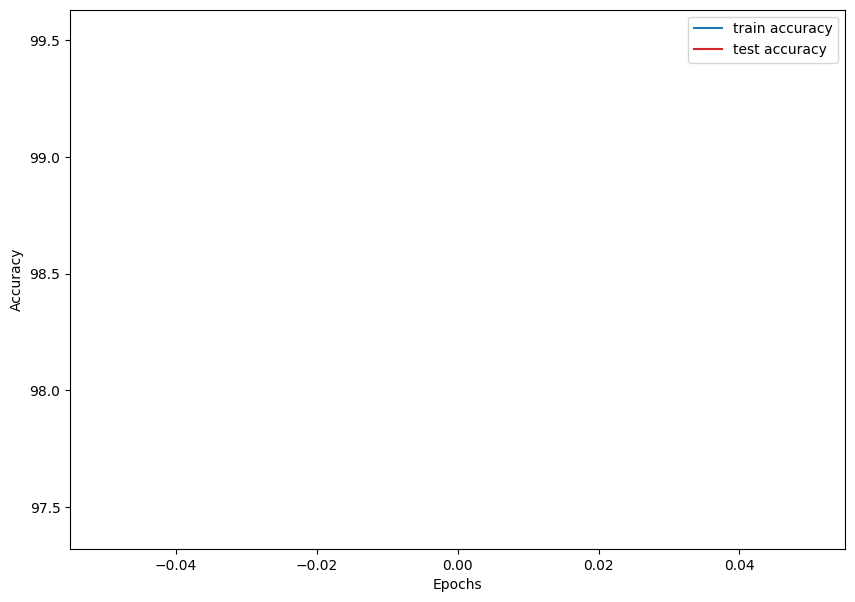

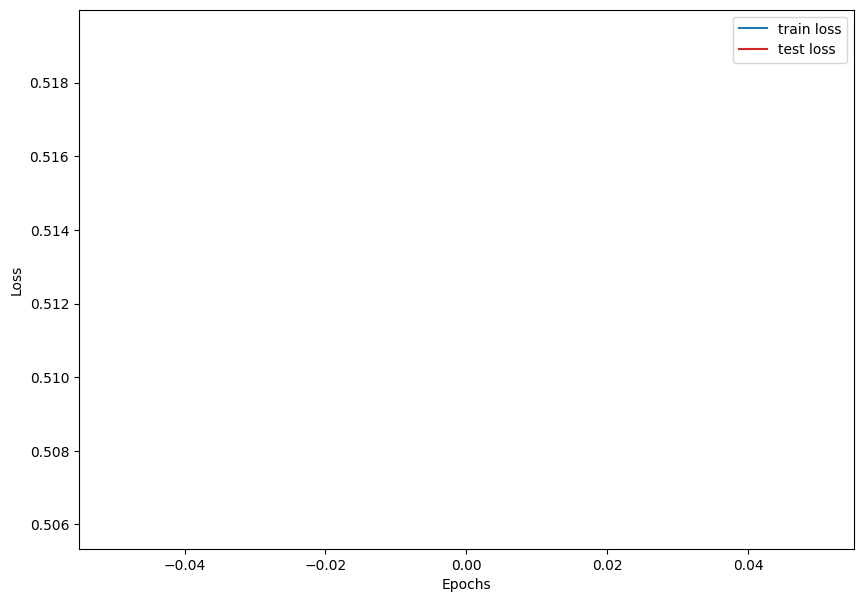

In [29]:
train_loss, test_loss = [], []
train_acc, test_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        model_ft, 
        train_dataloader, 
        optimizer,
        scheduler,
        criterion,
        device
    )
    print(scheduler.get_last_lr())
    test_epoch_loss, test_epoch_acc = test(
        model_ft, 
        test_dataloader, 
        criterion,
        device
    )
    
    if test_epoch_acc > max_test_acc:
        max_test_acc = test_epoch_acc
        best_model = copy.deepcopy(model_ft)
    
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    train_acc.append(train_epoch_acc)
    test_acc.append(test_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Test loss: {test_epoch_loss:.3f}, test acc: {test_epoch_acc:.3f}")
    print('-'*50)
        
# Save the loss and accuracy plots.
save_plots(
    train_acc, 
    test_acc, 
    train_loss, 
    test_loss, 
    name=plot_name
)
print('TRAINING COMPLETE')

In [70]:
test(
        best_model, 
        val_dataloader, 
        criterion,
        device
    )

Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:02<00:00,  6.37it/s]


(0.5064446929842233, 99.53)

In [30]:
err = []
for key in range(len(val_dataset)):
    img, label, _ = val_dataset[key]
    if label != torch.round(best_model(img[None,:].to(device))):
        err.append(key)

In [32]:
torch.round(best_model(val_dataset[key][0][None,:].to(device))).tolist()[0][0]
val_dataset[key][1]

0

In [76]:
y_pred = []
y = []
for key in range(len(val_dataset)):
    img, label, _ = val_dataset[key]
    temp = torch.round(best_model(img[None,:].to(device))).tolist()[0][0]
    y_pred.append(temp)
    y.append(label)

In [77]:
from sklearn.metrics import f1_score, precision_score, recall_score

print('F1-Score binary: ', f1_score(y, y_pred, average='binary'))
print('Precision score: ', precision_score(y, y_pred, average='binary'))
print('Recall score: ', recall_score(y, y_pred, average='binary'))

F1-Score binary:  0.995303287698611
Precision score:  0.9946075494307969
Recall score:  0.996


LogisticRegression: ROC AUC=0.996


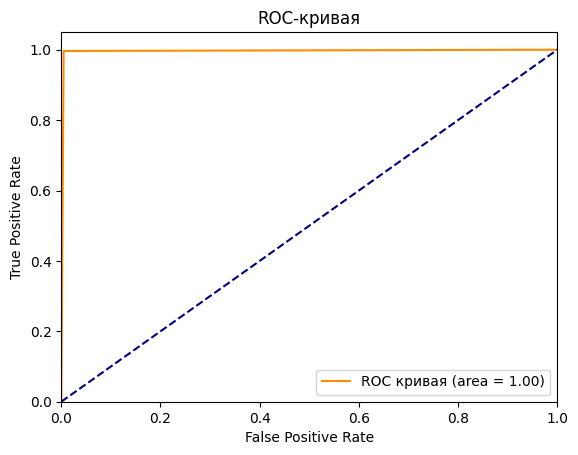

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt


lr_auc = roc_auc_score(y, y_pred)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

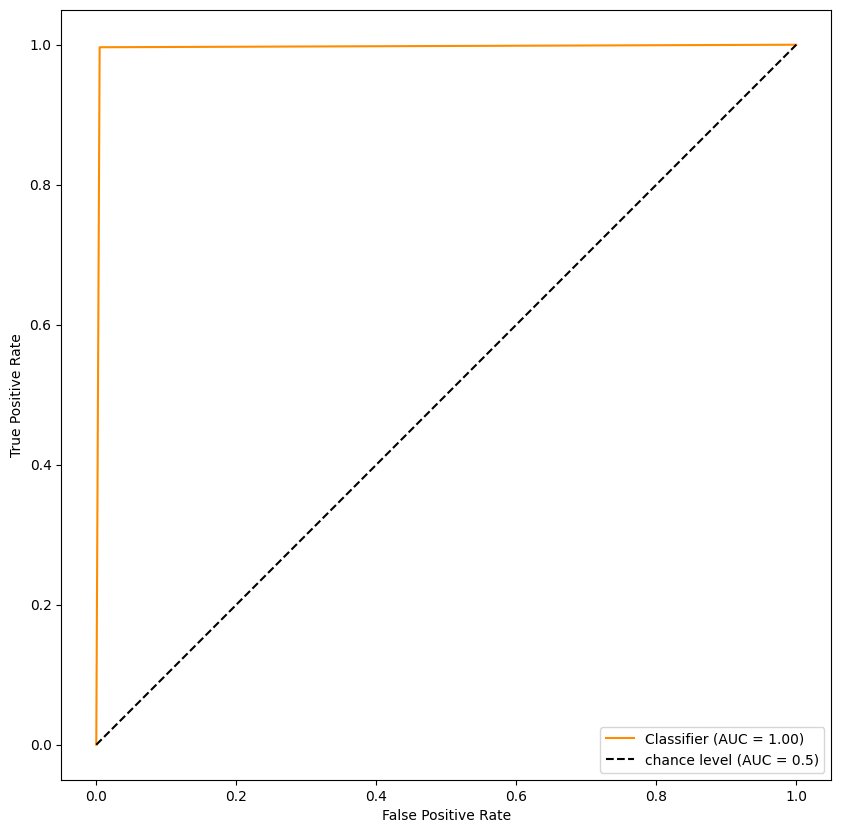

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, 

RocCurveDisplay.from_predictions(
    y,
    y_pred,
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
best_model(val_dataset[3][0][None,:].to(device))

In [31]:
err_array = []
for i in range(len(err)):
    temp_img, = best_model(val_dataset[err[i]][0][None,:].to(device))
    err_array.append(temp_img.tolist() + [int(val_dataset[err[i]][1]), val_dataset[err[i]][2]])

In [33]:
(1 - len(err)/len(val_dict))*100

99.53

[0.9230570793151855, 0, 'mushrooms/Phlebia radiata/000017.jpg']


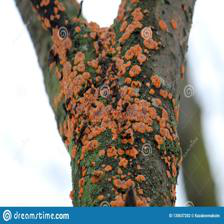

In [869]:
temp = err_array[0]
print(temp)
Image.open(temp[2])

In [36]:
len(err_array)

47

[0.9872555732727051, 0, 'mushrooms/Cordyceps militaris/000004.jpg']


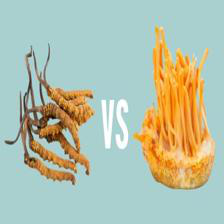

In [60]:
print(err_array[7])
Image.open(err_array[7][2])

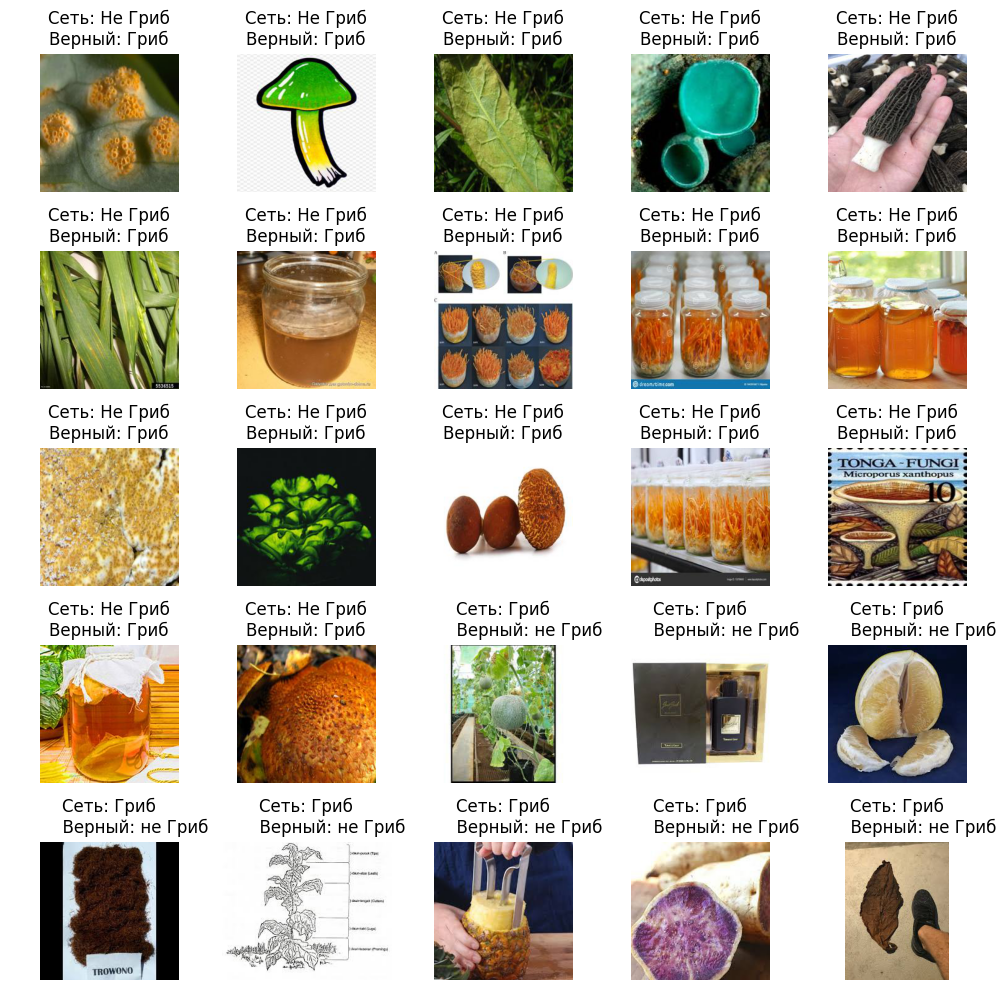

In [39]:
figure, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
j = 0
for i in err_array[10:35]:
    if i[1] != 1:
        text = 'Cеть: Не Гриб\nВерный: Гриб'
    else:
        text = 'Cеть: Гриб\n          Верный: не Гриб'
    image = mpimg.imread(i[2])
    ax.ravel()[j].imshow(image)
    ax.ravel()[j].title.set_text(text)
    ax.ravel()[j].set_axis_off()
    j += 1
plt.tight_layout()
plt.savefig('output.png')

In [ ]:
for baselr in [1e-5]:
    for maxlr in [3e-5 ,4e-5, 5e-5, 6e-5]:
        for wd in [1e-2, 1e-3, 1e-4]:

            model_ft = models.resnet18(pretrained=True)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = torch.nn.Linear(num_ftrs, 2)
            model_ft.to(device);

            # Optimizer.
            optimizer = optim.Adam(model_ft.parameters(), lr=learning_rate, weight_decay=wd)#optim.Adam(model_ft.parameters(), lr=learning_rate)
            scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=baselr, max_lr=maxlr, cycle_momentum=False, mode="triangular2", step_size_up=3000)

            # Loss function.
            criterion = nn.BCEWithLogitsLoss()
            train_loss, test_loss = [], []
            train_acc, test_acc = [], []

            # Start the training.
            for epoch in range(epochs):
                print(f"[INFO]: Epoch {epoch+1} of {epochs}")
                train_epoch_loss, train_epoch_acc = train(
                    model_ft, 
                    train_dataloader, 
                    optimizer,
                    scheduler,
                    criterion,
                    device
                )
                print(scheduler.get_last_lr())
                test_epoch_loss, test_epoch_acc = test(
                    model_ft, 
                    test_dataloader, 
                    criterion,
                    device
                )

                if test_epoch_acc > max_test_acc:
                    max_test_acc = test_epoch_acc
                    best_model = copy.deepcopy(model_ft)
                    inf = (baselr, maxlr, wd)
                    print(max_test_acc, inf)
            print('TRAINING COMPLETE')

In [61]:
def download_photo(link, name):
    url = link
    filename = name
    urllib.request.urlretrieve(url, filename)
    temp_preprocessing = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
            ])
    return temp_preprocessing(Image.open(name))

In [62]:
temp_link = "https://www.fda.gov/files/Mushrooms-SummaryStrategy-Listeriosis.png"
temp_img = download_photo(temp_link, "lenin.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


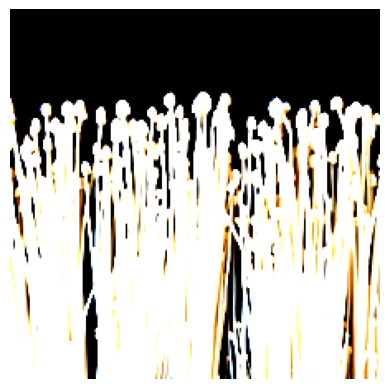

In [63]:
plt.imshow(temp_img.squeeze().permute(1,2,0))
plt.axis("off")
plt.show()

In [65]:
best_model(temp_img[None,:].to(device)).flatten()

tensor([0.1871], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [889]:
#working_model = copy.deepcopy(best_model)

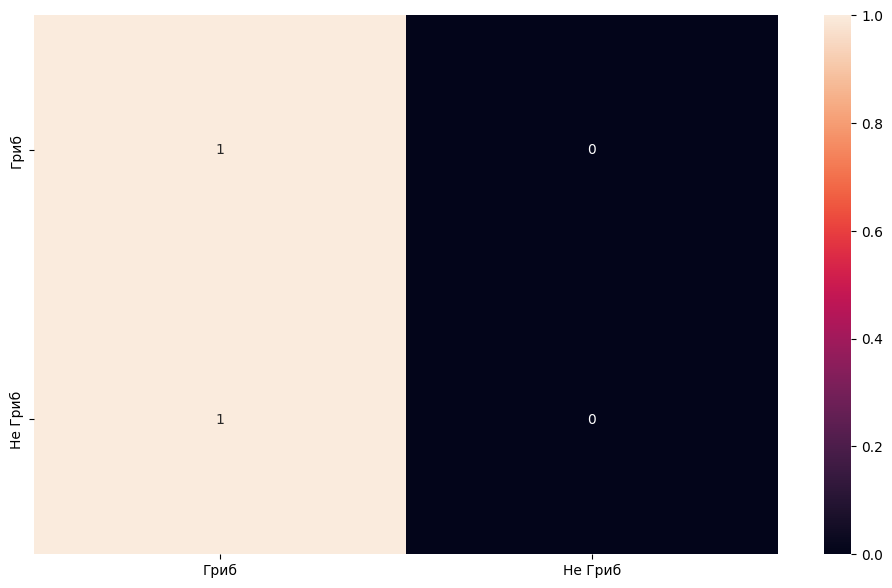

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels, _ in val_dataloader:
        output = best_model(inputs.to(device)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ("Гриб", "Не Гриб")

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')
#plt.show()